In [1]:
import pandas as pd
import numpy as np

# ==========================================
# 1. 配置路径 (请根据第一步的输出修改这里!)
# ==========================================

# 示例路径（你需要替换成你的真实路径）
# 如果你 Day 4 输出了 cleaned csv 并作为 dataset 添加了，就用那个。
# 否则，我们直接读取原始数据作为替代。
path_nsl_train = '/kaggle/input/nslkdd/KDDTrain+.txt' 
path_nsl_test  = '/kaggle/input/nslkdd/KDDTest+.txt'

# CIC-IDS 比较大，我们选其中一天的数据做实验即可 (比如周三)
# 如果不知道选哪个，找文件名带 "Wednesday" 或 "Friday" 的
path_cic_csv   = '/kaggle/input/cicids2017-cleaned-and-preprocessed/cicids2017_cleaned.csv'

# ==========================================
# 2. 定义 NSL-KDD 列名 (原始数据无Header)
# ==========================================
KDD_COLUMNS = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", 
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", 
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", 
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", 
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", 
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
    "label", "difficulty"
]

# ==========================================
# 3. 加载数据 (带内存保护)
# ==========================================
print("正在加载 NSL-KDD...")
try:
    # 【修正】加上 header=None，确保第一行 0,tcp... 被读作数据而不是表头
    df_kdd_train = pd.read_csv(path_nsl_train, header=None, names=KDD_COLUMNS)
    df_kdd_test = pd.read_csv(path_nsl_test, header=None, names=KDD_COLUMNS)
    print(f"NSL-KDD 修正后形状: Train {df_kdd_train.shape}, Test {df_kdd_test.shape}")
except Exception as e:
    print(f"NSL-KDD 加载失败，请检查路径: {e}")

print("\n正在加载 CIC-IDS-2017 (采样模式)...")
try:
    # 只读取前 10万行，防止 Kaggle 内存爆炸。
    # 我们的目的是跑通流程，不是为了在全量数据上刷分。
    df_cic = pd.read_csv(path_cic_csv)
    
    # 关键步骤：去除列名中的空格 (CIC-IDS 的老毛病)
    df_cic.columns = df_cic.columns.str.strip()
    
    # 采样 50,000 条数据用于文本实验
    df_cic_sampled = df_cic.sample(n=50000, random_state=42).copy()
    
    # 释放原始大变量，节省内存
    del df_cic 
    import gc
    gc.collect()
    
    print(f"CIC-IDS (采样后) 加载成功: {df_cic_sampled.shape}")
except Exception as e:
    print(f"CIC-IDS 加载失败，请检查路径: {e}")

# ==========================================
# 4. 定义伪日志模板 (The Templates)
# ==========================================

def create_pseudo_log_kdd(row):
    """NSL-KDD 转文本: 选取核心特征"""
    # 构造键值对字符串
    # 注意：这些特征名会在 TF-IDF 中成为词的一部分
    txt = (
        f"duration:{row['duration']} "
        f"proto:{row['protocol_type']} "
        f"service:{row['service']} "
        f"flag:{row['flag']} "
        f"src_bytes:{row['src_bytes']} "
        f"dst_bytes:{row['dst_bytes']} "
        f"count:{row['count']} "
        f"srv_count:{row['srv_count']} "
        f"logged_in:{row['logged_in']}"
    )
    return txt

def create_pseudo_log_cic(row):
    """CIC-IDS 转文本: 选取核心特征"""
    # 这里的列名必须和 df_cic.columns.str.strip() 后的结果一致
    # 使用 .get(key, 0) 防止列名不匹配报错
    txt = (
        f"dst_port:{row.get('Destination Port', 0)} "
        f"flow_dur:{row.get('Flow Duration', 0)} "
        f"tot_fwd_pkts:{row.get('Total Fwd Packets', 0)} "
        f"tot_bwd_pkts:{row.get('Total Backward Packets', 0)} "
        f"tot_len_fwd:{row.get('Total Length of Fwd Packets', 0)} "
        f"tot_len_bwd:{row.get('Total Length of Bwd Packets', 0)} "
        # 可以尝试加入 flag (虽然 CIC-IDS 的 flag 是分散的 boolean 列，这里简化处理)
    )
    return txt

# ==========================================
# 5. 预览结果 (Sanity Check)
# ==========================================
print("\n=== NSL-KDD 伪日志预览 (前3条) ===")
if 'df_kdd_train' in locals():
    for i in range(3):
        print(create_pseudo_log_kdd(df_kdd_train.iloc[i]))

print("\n=== CIC-IDS 伪日志预览 (前3条) ===")
if 'df_cic_sampled' in locals():
    for i in range(3):
        print(create_pseudo_log_cic(df_cic_sampled.iloc[i]))

正在加载 NSL-KDD...
NSL-KDD 修正后形状: Train (125973, 41), Test (22544, 41)

正在加载 CIC-IDS-2017 (采样模式)...
CIC-IDS (采样后) 加载成功: (50000, 53)

=== NSL-KDD 伪日志预览 (前3条) ===
duration:ftp_data proto:SF service:491 flag:0 src_bytes:0 dst_bytes:0 count:0.0 srv_count:0.0 logged_in:0
duration:other proto:SF service:146 flag:0 src_bytes:0 dst_bytes:0 count:0.0 srv_count:0.0 logged_in:0
duration:private proto:S0 service:0 flag:0 src_bytes:0 dst_bytes:0 count:1.0 srv_count:1.0 logged_in:0

=== CIC-IDS 伪日志预览 (前3条) ===
dst_port:53 flow_dur:30777 tot_fwd_pkts:4 tot_bwd_pkts:0 tot_len_fwd:124 tot_len_bwd:0 
dst_port:443 flow_dur:2884 tot_fwd_pkts:4 tot_bwd_pkts:0 tot_len_fwd:53 tot_len_bwd:0 
dst_port:80 flow_dur:73141122 tot_fwd_pkts:8 tot_bwd_pkts:0 tot_len_fwd:56 tot_len_bwd:0 


In [2]:
import pandas as pd
import numpy as np

# ==========================================
# 1. 路径配置 (保持你正确的路径)
# ==========================================
path_nsl_train = '/kaggle/input/nslkdd/KDDTrain+.txt' 
path_nsl_test  = '/kaggle/input/nslkdd/KDDTest+.txt'
path_cic_csv   = '/kaggle/input/cicids2017-cleaned-and-preprocessed/cicids2017_cleaned.csv'

# ==========================================
# 2. 定义 NSL-KDD 列名 (补全为 43 个!)
# ==========================================
KDD_COLUMNS = [
    # 基础特征 (1-9)
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", 
    "land", "wrong_fragment", "urgent", 
    # 内容特征 (10-22)
    "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", 
    "su_attempted", "num_root", "num_file_creations", "num_shells", 
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", 
    # 流量统计特征 (23-31)
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", 
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", 
    # 目标主机统计特征 (32-41) --> 之前漏了最后两个
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", 
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
    "dst_host_srv_serror_rate", 
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", # 【补回漏掉的两个】
    # 标签 (42-43)
    "label", "difficulty"
]

# ==========================================
# 3. 加载数据 (header=None)
# ==========================================
print("正在加载 NSL-KDD (Retry)...")
# 这里的 header=None 配合正确的 names 列表长度，将完美对齐
df_kdd_train = pd.read_csv(path_nsl_train, header=None, names=KDD_COLUMNS)
df_kdd_test = pd.read_csv(path_nsl_test, header=None, names=KDD_COLUMNS)

print(f"NSL-KDD 修正后形状: Train {df_kdd_train.shape}")
# 期望输出: (125973, 43)

# CIC-IDS 部分无需更改，你的结果是对的
print("\n正在加载 CIC-IDS-2017 (采样模式)...")
df_cic = pd.read_csv(path_cic_csv)
df_cic_sampled = df_cic.sample(n=50000, random_state=42).copy()

# ==========================================
# 4. 转换模板 (保持不变)
# ==========================================
def create_pseudo_log_kdd(row):
    txt = (
        f"duration:{row['duration']} "
        f"proto:{row['protocol_type']} "
        f"service:{row['service']} "
        f"flag:{row['flag']} "
        f"src_bytes:{row['src_bytes']} "
        f"dst_bytes:{row['dst_bytes']} "
        f"count:{row['count']} "
        f"srv_count:{row['srv_count']} "
        f"logged_in:{row['logged_in']}"
    )
    return txt

def create_pseudo_log_cic(row):
    # 使用 strip 后的列名
    row_idx = row.index.str.strip()
    # 构造一个临时的 clean row 来方便取值，或者直接在 get 里处理
    # 这里为了简单，直接假设 df_cic 的列名已经被处理过或者我们用 .get 模糊匹配
    txt = (
        f"dst_port:{row.get('Destination Port', row.get(' Destination Port', 0))} "
        f"flow_dur:{row.get('Flow Duration', row.get(' Flow Duration', 0))} "
        f"tot_fwd_pkts:{row.get('Total Fwd Packets', row.get(' Total Fwd Packets', 0))} "
        f"tot_bwd_pkts:{row.get('Total Backward Packets', row.get(' Total Backward Packets', 0))} "
        f"tot_len_fwd:{row.get('Total Length of Fwd Packets', row.get(' Total Length of Fwd Packets', 0))} "
        f"tot_len_bwd:{row.get('Total Length of Bwd Packets', row.get(' Total Length of Bwd Packets', 0))} "
    )
    return txt

# ==========================================
# 5. 验证结果
# ==========================================
print("\n=== NSL-KDD 伪日志预览 (期望: duration:0 proto:tcp...) ===")
for i in range(3):
    print(create_pseudo_log_kdd(df_kdd_train.iloc[i]))

print("\n=== CIC-IDS 伪日志预览 (确认: dst_port:53/80...) ===")
for i in range(3):
    print(create_pseudo_log_cic(df_cic_sampled.iloc[i]))

正在加载 NSL-KDD (Retry)...
NSL-KDD 修正后形状: Train (125973, 43)

正在加载 CIC-IDS-2017 (采样模式)...

=== NSL-KDD 伪日志预览 (期望: duration:0 proto:tcp...) ===
duration:0 proto:tcp service:ftp_data flag:SF src_bytes:491 dst_bytes:0 count:2 srv_count:2 logged_in:0
duration:0 proto:udp service:other flag:SF src_bytes:146 dst_bytes:0 count:13 srv_count:1 logged_in:0
duration:0 proto:tcp service:private flag:S0 src_bytes:0 dst_bytes:0 count:123 srv_count:6 logged_in:0

=== CIC-IDS 伪日志预览 (确认: dst_port:53/80...) ===
dst_port:53 flow_dur:30777 tot_fwd_pkts:4 tot_bwd_pkts:0 tot_len_fwd:124 tot_len_bwd:0 
dst_port:443 flow_dur:2884 tot_fwd_pkts:4 tot_bwd_pkts:0 tot_len_fwd:53 tot_len_bwd:0 
dst_port:80 flow_dur:73141122 tot_fwd_pkts:8 tot_bwd_pkts:0 tot_len_fwd:56 tot_len_bwd:0 


In [3]:
# ==========================================
# 4. 定义增强版伪日志模板 (Updated)
# ==========================================

def create_pseudo_log_kdd_enhanced(row):
    """
    NSL-KDD 增强版: 加入了重要的'行为类'特征
    """
    txt = (
        f"duration:{row['duration']} "
        f"proto:{row['protocol_type']} "
        f"service:{row['service']} "
        f"flag:{row['flag']} "
        f"src_bytes:{row['src_bytes']} "
        f"dst_bytes:{row['dst_bytes']} "
        # --- 新增：高危行为特征 ---
        f"urgent:{row['urgent']} "              # 紧急指针，通常用于 buffer overflow 攻击
        f"failed_logins:{row['num_failed_logins']} " # 暴力破解迹象
        f"root_shell:{row['root_shell']} "      # 极其危险：获得 root
        f"su_attempted:{row['su_attempted']} "  # 尝试切换用户
        f"file_creations:{row['num_file_creations']} " # 留后门迹象
        f"access_files:{row['num_access_files']} " # 数据窃取迹象
        # ------------------------
        f"count:{row['count']} "
        f"srv_count:{row['srv_count']} "
        f"logged_in:{row['logged_in']}"
    )
    return txt

def create_pseudo_log_cic_enhanced(row):
    """
    CIC-IDS 增强版: 加入了 TCP Flags (关键!)
    """
    # 辅助函数：安全获取列值（处理列名可能存在的空格）
    def get_val(col_name):
        # 尝试几种可能的列名写法
        for name in [col_name, " " + col_name, col_name.strip()]:
            if name in row.index:
                return row[name]
        return 0

    txt = (
        f"dst_port:{get_val('Destination Port')} "
        f"flow_dur:{get_val('Flow Duration')} "
        f"tot_fwd_pkts:{get_val('Total Fwd Packets')} "
        f"tot_bwd_pkts:{get_val('Total Backward Packets')} "
        f"tot_len_fwd:{get_val('Total Length of Fwd Packets')} "
        f"tot_len_bwd:{get_val('Total Length of Bwd Packets')} "
        # --- 新增：TCP Flags (扫描和DDoS的核心证据) ---
        f"fin_flag:{get_val('FIN Flag Count')} "
        f"syn_flag:{get_val('SYN Flag Count')} "
        f"rst_flag:{get_val('RST Flag Count')} "
        f"psh_flag:{get_val('PSH Flag Count')} "
        f"ack_flag:{get_val('ACK Flag Count')} "
        # ------------------------------------------
    )
    return txt

# ==========================================
# 5. 再次预览 (增强版)
# ==========================================
print("\n=== NSL-KDD 增强版伪日志预览 (含 root_shell 等) ===")
# 重新赋值函数指针，方便后面 P2 调用
create_pseudo_log_kdd = create_pseudo_log_kdd_enhanced
create_pseudo_log_cic = create_pseudo_log_cic_enhanced

for i in range(3):
    print(create_pseudo_log_kdd(df_kdd_train.iloc[i]))

print("\n=== CIC-IDS 增强版伪日志预览 (含 flags) ===")
for i in range(3):
    print(create_pseudo_log_cic(df_cic_sampled.iloc[i]))


=== NSL-KDD 增强版伪日志预览 (含 root_shell 等) ===
duration:0 proto:tcp service:ftp_data flag:SF src_bytes:491 dst_bytes:0 urgent:0 failed_logins:0 root_shell:0 su_attempted:0 file_creations:0 access_files:0 count:2 srv_count:2 logged_in:0
duration:0 proto:udp service:other flag:SF src_bytes:146 dst_bytes:0 urgent:0 failed_logins:0 root_shell:0 su_attempted:0 file_creations:0 access_files:0 count:13 srv_count:1 logged_in:0
duration:0 proto:tcp service:private flag:S0 src_bytes:0 dst_bytes:0 urgent:0 failed_logins:0 root_shell:0 su_attempted:0 file_creations:0 access_files:0 count:123 srv_count:6 logged_in:0

=== CIC-IDS 增强版伪日志预览 (含 flags) ===
dst_port:53 flow_dur:30777 tot_fwd_pkts:4 tot_bwd_pkts:0 tot_len_fwd:124 tot_len_bwd:0 fin_flag:0 syn_flag:0 rst_flag:0 psh_flag:0 ack_flag:0 
dst_port:443 flow_dur:2884 tot_fwd_pkts:4 tot_bwd_pkts:0 tot_len_fwd:53 tot_len_bwd:0 fin_flag:0 syn_flag:0 rst_flag:0 psh_flag:0 ack_flag:1 
dst_port:80 flow_dur:73141122 tot_fwd_pkts:8 tot_bwd_pkts:0 tot_len_fwd:

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# 开启 Pandas 的进度条支持
tqdm.pandas()

print("=== 开始执行 P2: 批量文本生成 (Strict Split Mode) ===")

# ==========================================
# 1. NSL-KDD 处理 (对齐 Day 4)
# ==========================================
print("\n[NSL-KDD 1/3] 生成 KDDTrain+ 的文本...")
# 这一步会处理 12.5万行，可能需要 10-20秒
df_kdd_train['log_text'] = df_kdd_train.progress_apply(create_pseudo_log_kdd, axis=1)

print("[NSL-KDD 2/3] 生成 KDDTest+ 的文本...")
df_kdd_test['log_text'] = df_kdd_test.progress_apply(create_pseudo_log_kdd, axis=1)

# --- 关键步骤：复刻 Day 4 的划分 ---
# 我们只保留 log_text 和 label 列，减少存储体积
kdd_full_train_export = df_kdd_train[['log_text', 'label']].copy()
kdd_test_export       = df_kdd_test[['log_text', 'label']].copy()

print("[NSL-KDD 3/3] 执行 90/10 切分 (Train/Val)...")
# 保持 random_state=42 和 stratify，确保和 Day 4 的分布一致
kdd_train_split, kdd_val_split = train_test_split(
    kdd_full_train_export,
    test_size=0.1, 
    random_state=42, 
    stratify=kdd_full_train_export['label']
)

# ==========================================
# 2. CIC-IDS 处理 (采样版)
# ==========================================
print("\n[CIC-IDS 1/2] 生成文本 (采样版)...")
df_cic_sampled['log_text'] = df_cic_sampled.progress_apply(create_pseudo_log_cic, axis=1)

# 统一 Label 列名
cic_label_col = 'Label' if 'Label' in df_cic_sampled.columns else ' Label'
df_cic_sampled = df_cic_sampled.rename(columns={cic_label_col: 'label'})
cic_full_export = df_cic_sampled[['log_text', 'label']].copy()

# --- 关键步骤：切分 ---
# 这里我们简化为 80/20，对应 Day 4 的 (Train+Val) / Test
print("[CIC-IDS 2/2] 执行 80/20 切分 (Train/Test)...")
cic_train_split, cic_test_split = train_test_split(
    cic_full_export, 
    test_size=0.2, 
    random_state=42, 
    stratify=cic_full_export['label']
)

# ==========================================
# 3. 持久化保存 (Parquet)
# ==========================================
print("\n[Output] 正在保存结果到 /kaggle/working/ ...")

# NSL-KDD (存 3 份: Train, Val, Test)
kdd_train_split.to_parquet('nsl_kdd_text_train.parquet', index=False)
kdd_val_split.to_parquet('nsl_kdd_text_val.parquet', index=False)
kdd_test_export.to_parquet('nsl_kdd_text_test.parquet', index=False)

# CIC-IDS (存 2 份: Train, Test)
cic_train_split.to_parquet('cic_ids_text_train.parquet', index=False)
cic_test_split.to_parquet('cic_ids_text_test.parquet', index=False)

# ==========================================
# 4. 最终检查
# ==========================================
print("\n=== P2 产出清单 ===")
print(f"1. NSL-KDD Train: {kdd_train_split.shape} (用于训练 TF-IDF 和模型)")
print(f"2. NSL-KDD Val:   {kdd_val_split.shape}   (用于调参，今天可能暂时不用)")
print(f"3. NSL-KDD Test:  {kdd_test_export.shape}   (用于最终评估，必须是 22544 行)")
print(f"4. CIC-IDS Train: {cic_train_split.shape}")
print(f"5. CIC-IDS Test:  {cic_test_split.shape}")

=== 开始执行 P2: 批量文本生成 (Strict Split Mode) ===

[NSL-KDD 1/3] 生成 KDDTrain+ 的文本...


  0%|          | 0/125973 [00:00<?, ?it/s]

[NSL-KDD 2/3] 生成 KDDTest+ 的文本...


  0%|          | 0/22544 [00:00<?, ?it/s]

[NSL-KDD 3/3] 执行 90/10 切分 (Train/Val)...

[CIC-IDS 1/2] 生成文本 (采样版)...


  0%|          | 0/50000 [00:00<?, ?it/s]

KeyError: "['label'] not in index"

In [ ]:
# 打印所有列名，看看 Label 长什么样
print("CIC-IDS 所有列名:")
print(list(df_cic_sampled.columns))

# 尝试自动寻找包含 "label" 的列
candidates = [c for c in df_cic_sampled.columns if 'label' in c.lower()]
print(f"\n自动探测到的疑似标签列: {candidates}")

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# 开启 Pandas 的进度条支持
tqdm.pandas()

print("=== 开始执行 P2: 批量文本生成 (Target: Attack Type) ===")

# ==========================================
# 1. NSL-KDD 处理 (跳过已完成的部分)
# ==========================================
if 'log_text' not in df_kdd_train.columns:
    print("[NSL-KDD] 生成 KDDTrain+ 文本...")
    df_kdd_train['log_text'] = df_kdd_train.progress_apply(create_pseudo_log_kdd, axis=1)

if 'log_text' not in df_kdd_test.columns:
    print("[NSL-KDD] 生成 KDDTest+ 文本...")
    df_kdd_test['log_text'] = df_kdd_test.progress_apply(create_pseudo_log_kdd, axis=1)

# 导出 NSL-KDD
kdd_full_train_export = df_kdd_train[['log_text', 'label']].copy()
kdd_test_export       = df_kdd_test[['log_text', 'label']].copy()

print("[NSL-KDD] 切分 90/10...")
kdd_train_split, kdd_val_split = train_test_split(
    kdd_full_train_export,
    test_size=0.1, 
    random_state=42, 
    stratify=kdd_full_train_export['label']
)

# ==========================================
# 2. CIC-IDS 处理 (针对 Attack Type)
# ==========================================
print("\n[CIC-IDS] 检查文本生成状态...")
if 'log_text' not in df_cic_sampled.columns:
    df_cic_sampled['log_text'] = df_cic_sampled.progress_apply(create_pseudo_log_cic, axis=1)
else:
    print(" -> 文本列已存在，跳过生成。")

# --- 关键修复逻辑 ---
target_col = None
if 'Attack Type' in df_cic_sampled.columns:
    target_col = 'Attack Type'
elif 'Label' in df_cic_sampled.columns:
    target_col = 'Label'
elif ' Label' in df_cic_sampled.columns:
    target_col = ' Label'

if target_col:
    print(f" -> 锁定标签列: '{target_col}'，正在重命名为 'label'...")
    df_cic_sampled = df_cic_sampled.rename(columns={target_col: 'label'})
else:
    raise KeyError(f"仍然找不到标签列！当前列名: {df_cic_sampled.columns}")

# 导出 CIC-IDS
cic_full_export = df_cic_sampled[['log_text', 'label']].copy()

print("[CIC-IDS] 切分 80/20...")
cic_train_split, cic_test_split = train_test_split(
    cic_full_export, 
    test_size=0.2, 
    random_state=42, 
    stratify=cic_full_export['label']
)

# ==========================================
# 3. 持久化保存
# ==========================================
print("\n[Output] 保存所有 Parquet 文件...")

kdd_train_split.to_parquet('nsl_kdd_text_train.parquet', index=False)
kdd_val_split.to_parquet('nsl_kdd_text_val.parquet', index=False)
kdd_test_export.to_parquet('nsl_kdd_text_test.parquet', index=False)

cic_train_split.to_parquet('cic_ids_text_train.parquet', index=False)
cic_test_split.to_parquet('cic_ids_text_test.parquet', index=False)

print("\n=== P2 任务全部完成！ ===")
print(f"CIC-IDS Train: {cic_train_split.shape}")
print(f"CIC-IDS Test:  {cic_test_split.shape}")

=== 开始执行 P2: 批量文本生成 (Target: Attack Type) ===
[NSL-KDD] 切分 90/10...

[CIC-IDS] 检查文本生成状态...
 -> 文本列已存在，跳过生成。
 -> 锁定标签列: 'Attack Type'，正在重命名为 'label'...
[CIC-IDS] 切分 80/20...

[Output] 保存所有 Parquet 文件...

=== P2 任务全部完成！ ===
CIC-IDS Train: (40000, 2)
CIC-IDS Test:  (10000, 2)


In [6]:
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

print("=== 开始执行 P3: TF-IDF 文本向量化 ===")

# ==========================================
# 1. NSL-KDD 向量化
# ==========================================
print("\n[NSL-KDD] 正在加载 Parquet 数据...")
# 从 P2 的产出读取
kdd_train_df = pd.read_parquet('nsl_kdd_text_train.parquet')
kdd_test_df  = pd.read_parquet('nsl_kdd_text_test.parquet')

print(f"[NSL-KDD] 初始化 TF-IDF (Max Features=5000, Ngram=1-2)...")
# 初始化向量化器
tfidf_kdd = TfidfVectorizer(
    max_features=5000,  # 只保留最重要的 5000 个词/词组，防止维度爆炸
    ngram_range=(1, 2), # 既看 "tcp" 也看 "proto:tcp"
    token_pattern=r'(?u)\b\w[\w:]+\b' # 自定义正则：允许单词中包含冒号(:)，防止 "dst_port:80" 被切开
)

# 核心步骤：防泄露！只在 Train 上 Fit，在 Test 上 Transform
print("[NSL-KDD] Fitting & Transforming...")
X_kdd_train = tfidf_kdd.fit_transform(kdd_train_df['log_text'])
X_kdd_test  = tfidf_kdd.transform(kdd_test_df['log_text'])

# 提取标签 (y)
y_kdd_train = kdd_train_df['label']
y_kdd_test  = kdd_test_df['label']

# 保存向量化器 (Day 14 会用到)
joblib.dump(tfidf_kdd, 'tfidf_vectorizer_kdd.joblib')
print(f" -> NSL-KDD 矩阵形状: Train {X_kdd_train.shape}, Test {X_kdd_test.shape}")

# ==========================================
# 2. CIC-IDS 向量化
# ==========================================
print("\n[CIC-IDS] 正在加载 Parquet 数据...")
cic_train_df = pd.read_parquet('cic_ids_text_train.parquet')
cic_test_df  = pd.read_parquet('cic_ids_text_test.parquet')

print(f"[CIC-IDS] 初始化 TF-IDF...")
# CIC-IDS 需要独立的向量化器，因为它的特征词汇（端口号、攻击类型）和 KDD 不一样
tfidf_cic = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1, 2),
    token_pattern=r'(?u)\b\w[\w:]+\b'
)

print("[CIC-IDS] Fitting & Transforming...")
X_cic_train = tfidf_cic.fit_transform(cic_train_df['log_text'])
X_cic_test  = tfidf_cic.transform(cic_test_df['log_text'])

y_cic_train = cic_train_df['label']
y_cic_test  = cic_test_df['label']

joblib.dump(tfidf_cic, 'tfidf_vectorizer_cic.joblib')
print(f" -> CIC-IDS 矩阵形状: Train {X_cic_train.shape}, Test {X_cic_test.shape}")

# ==========================================
# 3. 窥探一下机器学到了什么 (Sanity Check)
# ==========================================
print("\n=== 词表抽查 (Vocabulary Inspection) ===")
# 看看机器认为最重要的词是什么
print("NSL-KDD 前 10 个特征词:", tfidf_kdd.get_feature_names_out()[:10])
print("NSL-KDD 随机 10 个特征词:", pd.Series(tfidf_kdd.get_feature_names_out()).sample(10).values)

print("\nP3 完成！数据已转化为稀疏矩阵 (Sparse Matrix)，准备进入 P4 训练。")

=== 开始执行 P3: TF-IDF 文本向量化 ===

[NSL-KDD] 正在加载 Parquet 数据...
[NSL-KDD] 初始化 TF-IDF (Max Features=5000, Ngram=1-2)...
[NSL-KDD] Fitting & Transforming...
 -> NSL-KDD 矩阵形状: Train (113375, 5000), Test (22544, 5000)

[CIC-IDS] 正在加载 Parquet 数据...
[CIC-IDS] 初始化 TF-IDF...
[CIC-IDS] Fitting & Transforming...
 -> CIC-IDS 矩阵形状: Train (40000, 5000), Test (10000, 5000)

=== 词表抽查 (Vocabulary Inspection) ===
NSL-KDD 前 10 个特征词: ['access_files:0' 'access_files:0 count:1' 'access_files:0 count:10'
 'access_files:0 count:100' 'access_files:0 count:101'
 'access_files:0 count:102' 'access_files:0 count:103'
 'access_files:0 count:104' 'access_files:0 count:105'
 'access_files:0 count:106']
NSL-KDD 随机 10 个特征词: ['flag:sf src_bytes:1206' 'src_bytes:61298 dst_bytes:0'
 'proto:tcp service:vmnet' 'src_bytes:88 dst_bytes:0'
 'count:128 srv_count:19' 'dst_bytes:633 urgent:0'
 'src_bytes:748 dst_bytes:0' 'dst_bytes:1761' 'access_files:0 count:234'
 'dst_bytes:2507']

P3 完成！数据已转化为稀疏矩阵 (Sparse Matrix)，准备进入 P4 训练。


In [7]:
import joblib
from sklearn.linear_model import LogisticRegression
import time

print("=== 开始执行 P4: 训练 NLP 基线模型 (Logistic Regression) ===")

# ==========================================
# 1. 训练 NSL-KDD 模型
# ==========================================
print("\n[NSL-KDD] 正在训练模型...")
start_time = time.time()

# 初始化逻辑回归
# solver='lbfgs': 经典的拟牛顿法，适合处理这种 5000 维的稀疏矩阵
# max_iter=1000: 增加迭代次数确保高维空间下能收敛
lr_kdd = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto', n_jobs=-1)

# 开始拟合 (训练)
lr_kdd.fit(X_kdd_train, y_kdd_train)

train_time_kdd = time.time() - start_time
print(f" -> NSL-KDD 训练完成! 耗时: {train_time_kdd:.2f}s")

# 保存模型
joblib.dump(lr_kdd, 'lr_text_model_kdd.joblib')

# ==========================================
# 2. 训练 CIC-IDS 模型
# ==========================================
print("\n[CIC-IDS] 正在训练模型...")
start_time = time.time()

# CIC-IDS 类别较多，逻辑回归会自动使用 One-vs-Rest (OvR) 策略
lr_cic = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto', n_jobs=-1)

# 开始拟合
lr_cic.fit(X_cic_train, y_cic_train)

train_time_cic = time.time() - start_time
print(f" -> CIC-IDS 训练完成! 耗时: {train_time_cic:.2f}s")

# 保存模型
joblib.dump(lr_cic, 'lr_text_model_cic.joblib')

print("\nP4 完成! 基线模型已保存为 .joblib 文件。")

=== 开始执行 P4: 训练 NLP 基线模型 (Logistic Regression) ===

[NSL-KDD] 正在训练模型...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 -> NSL-KDD 训练完成! 耗时: 13.27s

[CIC-IDS] 正在训练模型...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 -> CIC-IDS 训练完成! 耗时: 2.42s

P4 完成! 基线模型已保存为 .joblib 文件。



==================== NSL-KDD Text Baseline 评估结果 ====================
Accuracy: 0.7025

Classification Report:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

                 precision    recall  f1-score   support

        apache2     0.0000    0.0000    0.0000       737
           back     0.9489    0.9833    0.9658       359
buffer_overflow     0.3750    0.1500    0.2143        20
      ftp_write     0.0000    0.0000    0.0000         3
   guess_passwd     0.0000    0.0000    0.0000      1231
     httptunnel     0.0000    0.0000    0.0000       133
           imap     0.0000    0.0000    0.0000         1
        ipsweep     0.5128    0.9929    0.6763       141
           land     0.0000    0.0000    0.0000         7
     loadmodule     0.0000    0.0000    0.0000         2
       mailbomb     0.0000    0.0000    0.0000       293
          mscan     0.0000    0.0000    0.0000       996
       multihop     0.0000    0.0000    0.0000        18
          named     0.0000    0.0000    0.0000        17
        neptune     0.8535    0.9796    0.9122      4657
           nmap     0.9125    1.0000    0.9542        73
         normal     0.6572    

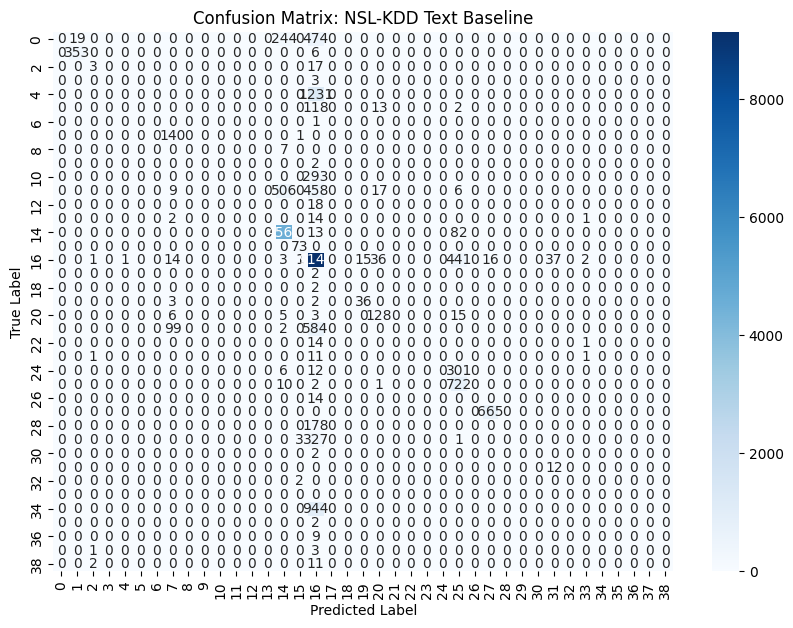


==================== CIC-IDS Text Baseline 评估结果 ====================
Accuracy: 0.9832

Classification Report:
                precision    recall  f1-score   support

          Bots     1.0000    0.1111    0.2000         9
   Brute Force     1.0000    1.0000    1.0000        36
          DDoS     0.9902    0.9921    0.9912       508
           DoS     0.9533    0.8660    0.9076       754
Normal Traffic     0.9850    0.9950    0.9900      8324
 Port Scanning     0.9861    0.9889    0.9875       360
   Web Attacks     0.0000    0.0000    0.0000         9

      accuracy                         0.9832     10000
     macro avg     0.8449    0.7076    0.7252     10000
  weighted avg     0.9821    0.9832    0.9822     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


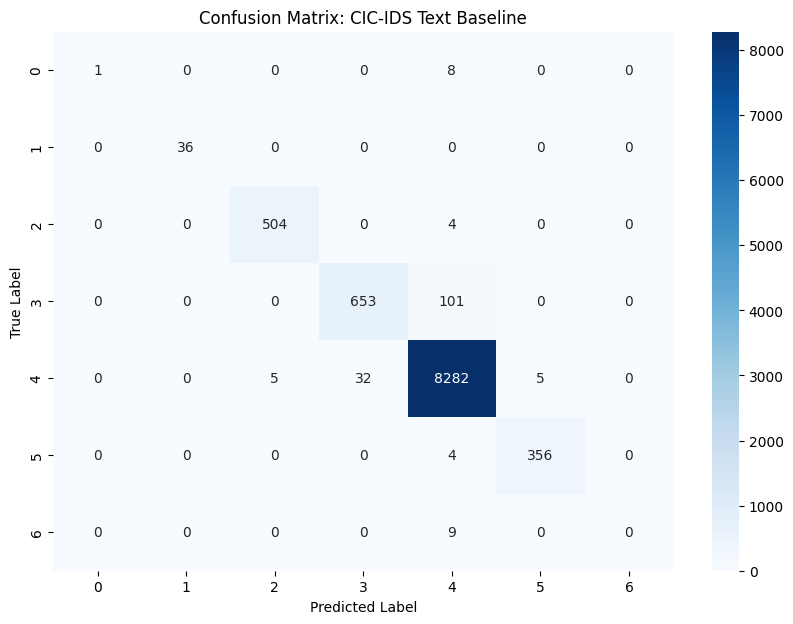

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def evaluate_text_model(model, X_test, y_test, title):
    # 预测
    y_pred = model.predict(X_test)
    
    # 基本指标
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{'='*20} {title} 评估结果 {'='*20}")
    print(f"Accuracy: {acc:.4f}")
    
    # 详细分类报告 (Precision, Recall, F1)
    # digits=4 为了看微小的性能差异
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    
    # 混淆矩阵可视化
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {title}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return acc

# 执行评估
acc_kdd_text = evaluate_text_model(lr_kdd, X_kdd_test, y_kdd_test, "NSL-KDD Text Baseline")
acc_cic_text = evaluate_text_model(lr_cic, X_cic_test, y_cic_test, "CIC-IDS Text Baseline")

In [9]:
def show_top_features(vectorizer, model, n=10):
    feature_names = vectorizer.get_feature_names_out()
    # 针对二分类（KDD 只有一维 coef），如果是多分类取第一类
    coefs = model.coef_[0] 
    
    # 关联词汇与权重
    top_features = sorted(zip(coefs, feature_names), reverse=True)
    
    print("\n最能代表攻击的 10 个关键词 (Top Positive Weights):")
    for weight, name in top_features[:n]:
        print(f"{name:<30} | Weight: {weight:.4f}")

    print("\n最能代表正常的 10 个关键词 (Top Negative Weights):")
    for weight, name in top_features[-n:]:
        print(f"{name:<30} | Weight: {weight:.4f}")

print("=== NSL-KDD 攻击指纹分析 ===")
show_top_features(tfidf_kdd, lr_kdd)

=== NSL-KDD 攻击指纹分析 ===

最能代表攻击的 10 个关键词 (Top Positive Weights):
src_bytes:54540                | Weight: 5.3593
service:http flag:rstr         | Weight: 4.9682
dst_bytes:8314 urgent:0        | Weight: 3.8847
dst_bytes:8314                 | Weight: 3.8847
src_bytes:54540 dst_bytes:8314 | Weight: 3.6434
flag:sf src_bytes:54540        | Weight: 3.6074
flag:rstr                      | Weight: 2.7467
service:http                   | Weight: 2.2374
proto:tcp service:http         | Weight: 2.2374
dst_bytes:7300 urgent:0        | Weight: 1.8388

最能代表正常的 10 个关键词 (Top Negative Weights):
flag:rej                       | Weight: -0.6554
access_files:0 count:1         | Weight: -0.6612
count:1                        | Weight: -0.6845
src_bytes:0 dst_bytes:0        | Weight: -0.8142
srv_count:1 logged_in:0        | Weight: -0.8536
src_bytes:0                    | Weight: -0.8678
srv_count:1                    | Weight: -0.9246
logged_in:0                    | Weight: -1.2139
dst_bytes:0 urgent:0   